---
### Coupling two probability distributions with high probability of equality  
---

**Course:** *Simulation and Monte Carlo Methods* (2nd Semester, ENSAE Paris)  
**Authors:** Piero PELOSI, Omar EL MAMOUNE, Sarakpy NY  
**Supervisor:** Yvann LE FAY

---

In [1]:
import numpy as np
from scipy.stats import norm
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

---
#### I. Quick introduction

Given two probability distributions $p$ and $q$, we are interested in constructing a joint distribution (coupling) for $(X,Y)$ such that $X \sim p$, $Y \sim q$, and $P(X=Y)$ is as large as possible. The paper [*The Coupled Rejection Sampler*](https://arxiv.org/abs/2201.09585) proposes a method to achieve this goal and shows how it can be applied to the case of two multivariate Gaussian distributions with different covariance matrices.

This project consists in implementing the proposed approach and comparing it with a simpler, classical algorithm known as Thorisson’s algorithm (Appendix 1 in the paper). We will explain why Thorisson’s algorithm is valid, how it relates to rejection sampling, and then examine several scenarios of increasing dimension. Since the running time of these algorithms is itself a random variable, we will also comment on its distribution and practical implications.

If time permits, we may additionally explore how such a coupling can be embedded in a random-walk Metropolis setting (as in Section 5.3 of the reference paper), and attempt to replicate some of those experiments. 

---
#### II. The coupled rejection-sampling method

Let $p$ and $q$ be two probability densities defined on $\chi$. We define a diagonal coupling of $p$ and $q$ in the following way.

**Definition 1** (Diagonal coupling). *A pair of random variables $(X, Y)$ defined on the same probability space and taking values in $\chi$ is a diagonal coupling of the probability densities $p$ and $q$ if and only if it is a coupling, that is, if*

$$
\mathbb{P}(X \in A) = \int_A p(x)\,dx, \quad \mathbb{P}(Y \in A) = \int_A q(x)\,dx,
$$

*for all measurable sets $A \subset \chi$, and if $\mathbb{P}(X = Y) > 0$.*

With this definition, a maximal coupling (Thorisson, 2000; Lindvall, 2002) is a diagonal coupling with maximal mass on the diagonal event $\{X = Y\}$.

In order to construct the acceptance-rejection scheme, we need the following definition.

**Definition 2** (Dominating pair). *Let $(\hat{p}, \hat{q})$ be a pair of probability densities. We say that it dominates $(p, q)$ (or that $(p, q) \preceq (\hat{p}, \hat{q})$) if and only if there exists $1 \leq M(p, \hat{p}) < \infty$ and $1 \leq M(q, \hat{q}) < \infty$ such that for any $x \in \mathbb{R}^d$ we have*

$$
p(x) \leq M(p, \hat{p})\, \hat{p}(x), \quad q(x) \leq M(q, \hat{q})\, \hat{q}(x).
$$

Now, suppose that we have a diagonal coupling $\hat{\Gamma}$ of $\hat{p}$ and $\hat{q}$ dominating the independent coupling $(p \otimes q)(x, y) = p(x)\, q(y)$. It turns out that we can produce samples from a diagonal coupling $\Gamma$ with marginals $p$ and $q$ by using an acceptance-rejection scheme with the coupling $\hat{\Gamma}$ as the proposal. 

Algorithm **1** shows how to do this and will be implemented below.

<div align="center">
    <img src="Images/Rejection-coupling.algo.png" alt="Rejection-coupling of (p,q)" width="600"/>
</div>

In [3]:
def rejection_coupling(p, q, hat_p, hat_q, sample_hat_gamma, sample_pq, M_p, M_q):
    A_x, A_y = 0, 0                          # Acceptance flags

    while A_x == 0 and A_y == 0:
        X1, Y1 = sample_hat_gamma()          # Sample from diagonal coupling hat_Gamma
        U = np.random.uniform(0, 1)

        if U < p(X1) / (M_p * hat_p(X1)):
            A_x = 1
        if U < q(Y1) / (M_q * hat_q(Y1)):
            A_y = 1

    X2, Y2 = sample_pq()                     # Sample from independent p ⊗ q

    X = A_x * X1 + (1 - A_x) * X2
    Y = A_y * Y1 + (1 - A_y) * Y2

    return X, Y

In [12]:
# Parameters
mu_p, sigma_p = 0.0, 1.0        # p ~ N(0, 1)
mu_q, sigma_q = 0.0, 2.0        # q ~ N(0, 4)
hat_sigma = 2.5

# Densities
p = lambda x: norm(loc=mu_p, scale=sigma_p).pdf(x)
q = lambda y: norm(loc=mu_q, scale=sigma_q).pdf(y)
hat_p = lambda x: norm(loc=mu_p, scale=hat_sigma).pdf(x)
hat_q = lambda y: norm(loc=mu_q, scale=hat_sigma).pdf(y)

# Constants
M_p = hat_sigma / sigma_p
M_q = hat_sigma / sigma_q

# Samplers
sample_hat_gamma = lambda: (norm(loc=mu_p, scale=hat_sigma).rvs(), norm(loc=mu_q, scale=hat_sigma).rvs())
sample_pq = lambda: (norm(loc=mu_p, scale=sigma_p).rvs(), norm(loc=mu_q, scale=sigma_q).rvs())

# Generate samples
n = 1000
X_values, Y_values = zip(*[rejection_coupling(p, q, hat_p, hat_q, sample_hat_gamma, sample_pq, M_p, M_q)
                           for _ in range(n)])
epsilon = 1e-8  # tolerance for floating-point equality

results = [rejection_coupling(p, q, hat_p, hat_q, sample_hat_gamma, sample_pq, M_p, M_q)
           for _ in range(n)]

matches = sum(abs(x - y) < epsilon for x, y in results)
percentage = (matches / n) * 100

print(f"Approximate matches (|X - Y| < {epsilon}): {matches}/{n} ({percentage:.2f}%)")

Approximate matches (|X - Y| < 1e-08): 0/1000 (0.00%)


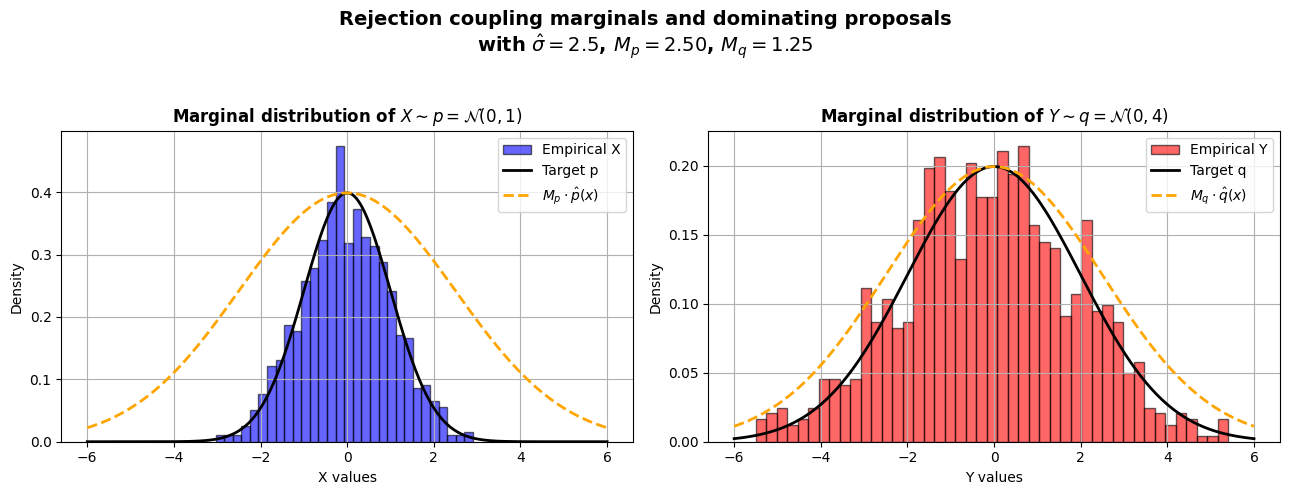

In [4]:
# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5))
x_grid = np.linspace(-6, 6, 300)

# Scaled proposal curves
hat_p_scaled = lambda x: M_p * norm.pdf(x, mu_p, hat_sigma)
hat_q_scaled = lambda x: M_q * norm.pdf(x, mu_q, hat_sigma)

ax1.hist(X_values, bins=30, alpha=0.6, color='blue', edgecolor='black', density=True, label="Empirical X")
ax1.plot(x_grid, norm.pdf(x_grid, mu_p, sigma_p), color='black', linewidth=2, label="Target p")
ax1.plot(x_grid, hat_p_scaled(x_grid), color='orange', linestyle='--', linewidth=2, label=r"$M_p \cdot \hat{p}(x)$")
ax1.set_title(r"Marginal distribution of $X \sim p = \mathcal{N}(0, 1)$", fontweight='bold')
ax1.set_xlabel("X values")
ax1.set_ylabel("Density")
ax1.legend()
ax1.grid(True)

ax2.hist(Y_values, bins=45, alpha=0.6, color='red', edgecolor='black', density=True, label="Empirical Y")
ax2.plot(x_grid, norm.pdf(x_grid, mu_q, sigma_q), color='black', linewidth=2, label="Target q")
ax2.plot(x_grid, hat_q_scaled(x_grid), color='orange', linestyle='--', linewidth=2, label=r"$M_q \cdot \hat{q}(x)$")
ax2.set_title(r"Marginal distribution of $Y \sim q = \mathcal{N}(0, 4)$", fontweight='bold')
ax2.set_xlabel("Y values")
ax2.set_ylabel("Density")
ax2.legend()
ax2.grid(True)

plt.suptitle(
    rf"Rejection coupling marginals and dominating proposals" "\n"
    rf"with $\hat{{\sigma}} = {hat_sigma}$, $M_p = {M_p:.2f}$, $M_q = {M_q:.2f}$",
    fontsize=14,
    fontweight='bold'
)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

---
#### III. The ensemble coupled rejection-sampling method

As mentioned in **Section 2**, the success probability of the coupling defined by Algorithm 1 is highly dependent on the acceptance probability of the marginal rejection subroutine. In fact, if the latter goes to $0$ (which is typically the case when the dimension of the sampling space increases), the former will too. Thankfully, in *Deligiannidis et al. (2020)*, the authors introduce an ensemble rejection sampler which increases the acceptance probability of a rejection-sampling algorithm by considering not one, but several proposals. Formally, if pRS is the probability of accepting a sample in the classical rejection sampling algorithm, then their ensemble rejection-sampler with $N$ proposals has probability $p_{ERS} \geq \frac{Np_{RS}}{1 + (N - 1)p_{RS}}$ to result in an accepted sample (Deligiannidis et al., 2020, Proposition $1$).

In order to do so, the authors form the self-normalized importance sample 
$$\sum_{i=1}^{N} W_i \delta_{X_i}$$
where $X_i \sim \hat{p}, i = 1, \ldots, N$ are i.i.d., 
$w_i = \frac{p(X_i)}{\hat{p}(X_i)}$, 
$W_i = \frac{w_i}{\sum_{j=1}^{N} w_j}$ for $i = 1, \ldots, N$. 

When this is done, they sample $I$ from a categorical distribution 
$\text{Cat}((W_i)_{i=1}^{N})$, and then accept the proposal $X_I$ with probability

$$
\frac{\sum_{i=1}^{N} w_i}{M(p, \hat{p}) + \sum_{i \ne I} w_i}.
$$

In order to improve the acceptance rate of Algorithm 1, we could decide to replace the rejection sampling step by the ensemble rejection sampling one and *Propositions 1 and 2* would essentially remain unchanged. However, in practice, sampling I and J independently from the categorical distributions corresponding to the p and q component, respectively, would not result in a large probability for the event $I = J$, even if the corresponding weights are close and using common random numbers.

Thankfully, it is easy to sample from a maximal coupling of multinomial distributions (see, e.g., *Thorisson, 2000, Section 4.2*), and we can therefore write a coupled version of the ensemble rejection sampler. This is summarized in Algorithm 2.

In the remainder of this section, all the quantities $X$, $Y$, $P(X= Y)$ and $P(I= J)$ implicitly depend on the number of proposals N in the sampled ensemble. However, we do not notationally emphasize this dependency for the sake of readibility.

**Algorithm 2** 

<div align="center">
    <img src="Images/Ensemble_rejection_coupling_algo.png" alt="Rejection-coupling of (p,q)" width="600"/>
</div>



In [22]:
def maximal_coupling_categorical(p, q):
    """
    Sample from the maximal coupling of two categorical distributions.

    Parameters:
    - p: probabilities of the first categorical distribution.
    - q: probabilities of the second categorical distribution.
    
    Returns:
    - i: index sampled from the first distribution.
    - j: index sampled from the second distribution.
    """
    assert np.all(p >= 0) and np.all(q >= 0)   # Ensure non-negativity
    assert np.isclose(np.sum(p), 1) and np.isclose(np.sum(q), 1) # Ensure valid probabilities
    
    N = len(p)
    min_pq = np.minimum(p, q)
    total_min = np.sum(min_pq)
    
    if np.random.rand() < total_min:
        i = np.random.choice(N, p=min_pq / total_min)   # Sample from the minimu
        return i, i
    else:
        I = np.random.choice(N, p=p)    # Sample from the first distribution
        J = np.random.choice(N, p=q)    # Sample from the second distribution
        return I, J

In [ ]:
def ensemble_rejection_coupling(Gamma, p, q, p_hat, M_p, M_q, N, sample_from_pq):
    """
    Perform ensemble rejection coupling.

    Parameters:
    - Gamma: function to sample from the coupling.
    - p: target distribution.
    - q: target distribution.
    - p_hat: proposal distribution.
    - M_p: scaling factor for p.
    - M_q: scaling factor for q.
    - N: number of samples.
    - sample_from_pq: function to sample from p and q independently.

    Returns:
    - X: sampled value from p.
    - Y: sampled value from q.
    """

    A_X, A_Y = 0, 0                     # Acceptance flags
    while A_X == 0 and A_Y == 0:
        # Sample from the coupling
        X_hat, Y_hat = zip(*[Gamma() for _ in range(N)])
        X_hat = np.array(X_hat)
        Y_hat = np.array(Y_hat)
        U = np.random.rand()

        # Compute weights
        w_X = np.array([p(xi) / p_hat(xi) for xi in X_hat])
        w_Y = np.array([q(yi) / p_hat(yi) for yi in Y_hat])
        Z_hat_X = np.mean(w_X)
        Z_hat_Y = np.mean(w_Y)

        W_X = w_X / (N * Z_hat_X)   
        W_Y = w_Y / (N * Z_hat_Y)

        # Sample from the maximal coupling
        I, J = maximal_coupling_categorical(W_X, W_Y)

        # Compute acceptance probabilities
        Z_bar_X = Z_hat_X + (M_p - w_X[I]) / N
        Z_bar_Y = Z_hat_Y + (M_q - w_Y[J]) / N

        X_1 = X_hat[I]
        Y_1 = Y_hat[J]

        # Acceptance criteria
        if U < Z_hat_X / Z_bar_X:
            A_X = 1
        if U < Z_hat_Y / Z_bar_Y:
            A_Y = 1
    
    # Sample from independent p ⊗ q
    X_2, Y_2 = sample_from_pq()

    # Combine samples
    X = A_X * X_1 + (1 - A_X) * X_2
    Y = A_Y * Y_1 + (1 - A_Y) * Y_2
    
    return X, Y

In [ ]:
# Parameters 
mu_p, sigma_p = 0.0, 1.0
mu_q, sigma_q = 0.0, 2.0
hat_sigma = 2.5

# Densities
p = lambda x: norm(loc=mu_p, scale=sigma_p).pdf(x) # p ~ N(0, 1)
q = lambda y: norm(loc=mu_q, scale=sigma_q).pdf(y) # q ~ N(0, 4)
hat_p = lambda x: norm(loc=mu_p, scale=hat_sigma).pdf(x) # hat_p ~ N(0, 2.5)

# Constants
M_p = hat_sigma / sigma_p 
M_q = hat_sigma / sigma_q

# Samplers
sample_hat_gamma = lambda: (
    norm(loc=mu_p, scale=hat_sigma).rvs(),
    norm(loc=mu_q, scale=hat_sigma).rvs()
)
sample_pq = lambda: (
    norm(loc=mu_p, scale=sigma_p).rvs(),
    norm(loc=mu_q, scale=sigma_q).rvs()
)

# Run the experiment
n = 1000 # Number of samples
N_ensemble = 10 # Number of samples in the ensemble
epsilon = 1e-8 # tolerance for floating-point equality

results = [ensemble_rejection_coupling(sample_hat_gamma, p, q, hat_p, M_p, M_q, N_ensemble, sample_pq)
           for _ in range(n)] 

# Count approximate matches
matches = sum(abs(x - y) < epsilon for x, y in results)
percentage = (matches / n) * 100

print(f"Algorithms 2 : approximate matches (|X - Y| < {epsilon}): {matches}/{n} ({percentage:.2f}%)")

Algorithms 2 : approximate matches (|X - Y| < 1e-08): 0/1000 (0.00%)


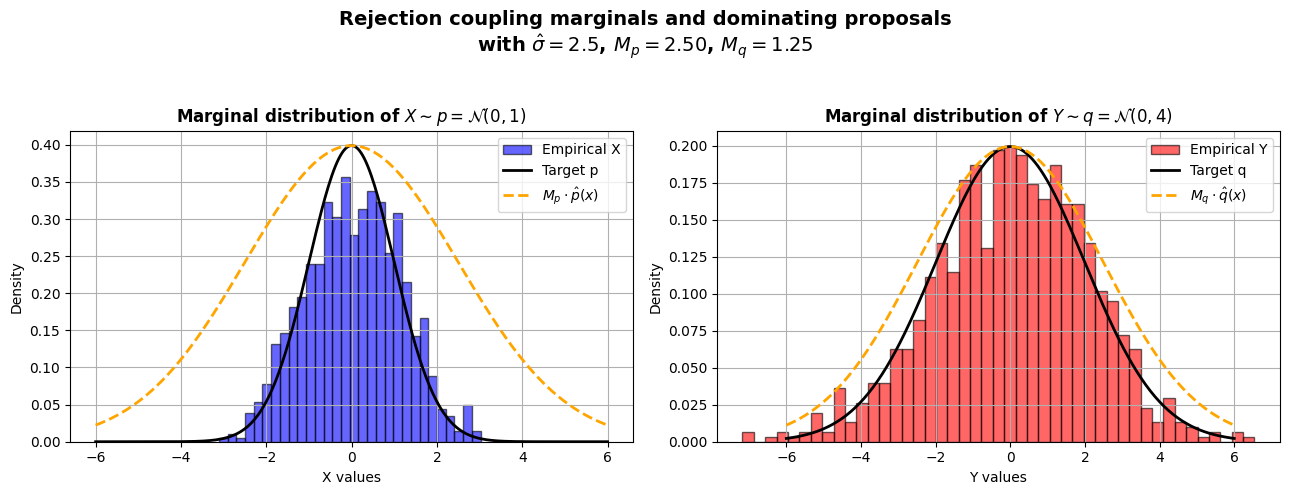

In [18]:
# Define X_vals and Y_vals from the results
X_vals, Y_vals = zip(*results)

# Re-run the plot with the now-defined X_vals and Y_vals
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5))
x_grid = np.linspace(-6, 6, 300)

# Scaled proposal curves
hat_p_scaled = lambda x: M_p * norm.pdf(x, mu_p, hat_sigma)
hat_q_scaled = lambda x: M_q * norm.pdf(x, mu_q, hat_sigma)

# Plot X
ax1.hist(X_vals, bins=30, alpha=0.6, color='blue', edgecolor='black', density=True, label="Empirical X")
ax1.plot(x_grid, norm.pdf(x_grid, mu_p, sigma_p), color='black', linewidth=2, label="Target p")
ax1.plot(x_grid, hat_p_scaled(x_grid), color='orange', linestyle='--', linewidth=2, label=r"$M_p \cdot \hat{p}(x)$")
ax1.set_title(r"Marginal distribution of $X \sim p = \mathcal{N}(0, 1)$", fontweight='bold')
ax1.set_xlabel("X values")
ax1.set_ylabel("Density")
ax1.legend()
ax1.grid(True)

# Plot Y
ax2.hist(Y_vals, bins=45, alpha=0.6, color='red', edgecolor='black', density=True, label="Empirical Y")
ax2.plot(x_grid, norm.pdf(x_grid, mu_q, sigma_q), color='black', linewidth=2, label="Target q")
ax2.plot(x_grid, hat_q_scaled(x_grid), color='orange', linestyle='--', linewidth=2, label=r"$M_q \cdot \hat{q}(x)$")
ax2.set_title(r"Marginal distribution of $Y \sim q = \mathcal{N}(0, 4)$", fontweight='bold')
ax2.set_xlabel("Y values")
ax2.set_ylabel("Density")
ax2.legend()
ax2.grid(True)

# Super title
plt.suptitle(
    rf"Rejection coupling marginals and dominating proposals" "\n"
    rf"with $\hat{{\sigma}} = {hat_sigma}$, $M_p = {M_p:.2f}$, $M_q = {M_q:.2f}$",
    fontsize=14,
    fontweight='bold'
)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


---
#### IV. The multidimensional Gaussian case

**Proposition 5** — *Gaussian Diagonal Coupling via a Dominating Covariance Matrix*

Our goal is to use **Algorithm 1** to sample from a coupling of 
$\mathcal{N}(\mu_p, \Sigma_p)$ and $\mathcal{N}(\mu_q, \Sigma_q)$, 
where the Gaussians have **different means and covariances**.

To do this, we use a **maximal coupling** between Gaussians that share a **common covariance matrix** $\hat{\Sigma}$ as the proposal $\hat{\Gamma}$, following the method of 
Bou-Rabee et al. (2020), known as the **reflection-maximal coupling** (see Appendix D).

**Conditions on the matrix $\hat{\Sigma}$**: to ensure that $\hat{\Gamma}$ is a **diagonal dominating coupling**, the matrix covariance $\hat{\Sigma}$ must satisfy:

- $\hat{\Sigma}^{-1} \preceq \Sigma_p^{-1}$
- $\hat{\Sigma}^{-1} \preceq \Sigma_q^{-1}$

**Consequences on the densities**: under these conditions, for all $x$ we have:

$$
\mathcal{N}(x; \mu_p, \Sigma_p) \leq \frac{\det(2\pi \hat{\Sigma})^{1/2}}{\det(2\pi \Sigma_p)^{1/2}} \, \mathcal{N}(x; \mu_p, \hat{\Sigma})
$$

and similarly:

$$
\mathcal{N}(x; \mu_q, \Sigma_q) \leq \frac{\det(2\pi \hat{\Sigma})^{1/2}}{\det(2\pi \Sigma_q)^{1/2}} \, \mathcal{N}(x; \mu_q, \hat{\Sigma})
$$

This shows that $\mathcal{N}(\mu_p, \hat{\Sigma})$ and $\mathcal{N}(\mu_q, \hat{\Sigma})$ are **dominant proposals** for $p$ and $q$ respectively. Then, setting the **domination constants**:

- $M(p, \hat{p}) = \dfrac{\det(2\pi \hat{\Sigma})^{1/2}}{\det(2\pi \Sigma_p)^{1/2}}$
- $M(q, \hat{q}) = \dfrac{\det(2\pi \hat{\Sigma})^{1/2}}{\det(2\pi \Sigma_q)^{1/2}}$

We get that **Algorithm 1**, applied to $\hat{\Gamma}$, $\mathcal{N}(\mu_p, \Sigma_p)$, and $\mathcal{N}(\mu_q, \Sigma_q)$, returns a **diagonal coupling** of $\mathcal{N}(\mu_p, \Sigma_p)$ and $\mathcal{N}(\mu_q, \Sigma_q)$.

---
#### V. Thorisson algorithm
In this section, we implement the following version of the *Modified Thorisson algorithm*, found in the appendix, page 31.

<div align="center">
    <img src="Images/Thorisson.algo.mod.png" alt="Modified Thorisson algorithm" width="600"/>
</div>

In [5]:
def thorisson_coupling(sample_p, pdf_p, sample_q, pdf_q, C):
    X = sample_p()
    U = np.random.uniform(0, 1)
    if U < min((pdf_q(X) / pdf_p(X)), C):
        Y = X
    else:
        A = 0
        while A != 1:
            U = np.random.uniform(0, 1)
            Z = sample_q()
            if U > min(1, C * pdf_p(Z) / pdf_q(Z)):
                A = 1
            Y = Z
    return X, Y

In [11]:
# Parameters
mu_p, sigma_p = 0.0, 1.0
mu_q, sigma_q = 0.0, 2.0
C = 1.0

# Distributions
sample_p = lambda: norm(loc=mu_p, scale=sigma_p).rvs()
pdf_p = lambda x: norm(loc=mu_p, scale=sigma_p).pdf(x)

sample_q = lambda: norm(loc=mu_q, scale=sigma_q).rvs()
pdf_q = lambda x: norm(loc=mu_q, scale=sigma_q).pdf(x)

# # Generate samples
n = 1000
np.random.seed(87)
results = [thorisson_coupling(sample_p, pdf_p, sample_q, pdf_q, C) for _ in range(n)]
X_values, Y_values = zip(*results)

# Match analysis
matches = [x == y for x, y in zip(X_values, Y_values)]
match_count = sum(matches)
match_percentage = (match_count / n) * 100

print(f"Number of matches (X = Y): {match_count} out of {n}.")
print(f"Percentage of matches: {match_percentage:.2f}%.")

Number of matches (X = Y): 681 out of 1000.
Percentage of matches: 68.10%.


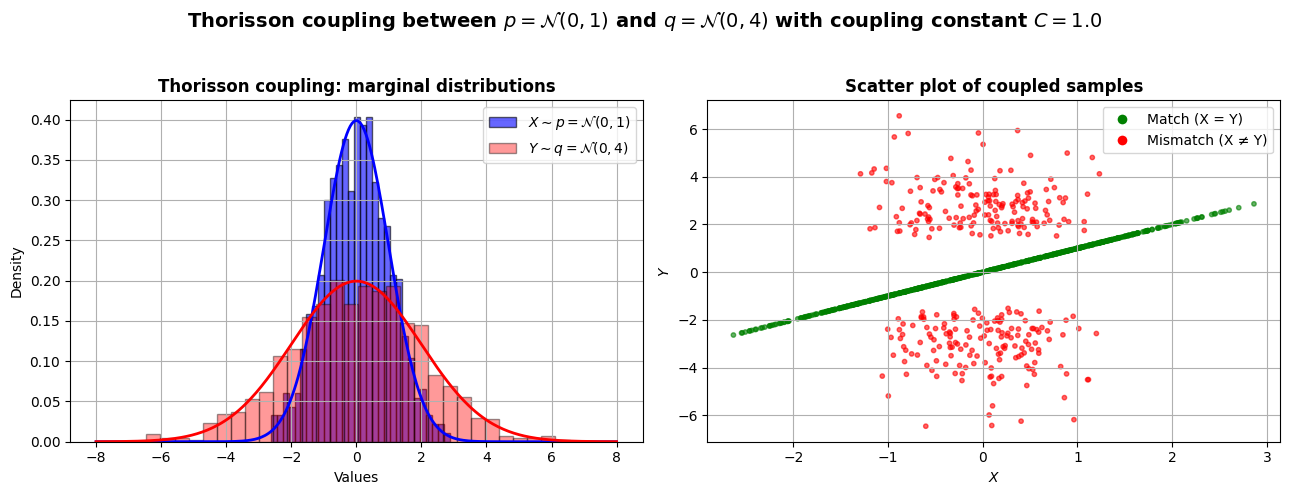

In [7]:
# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5))
x_grid = np.linspace(-8, 8, 300)

# Histogram of marginals
ax1.hist(X_values, bins=30, alpha=0.6, color='blue', edgecolor='black', label=r"$X \sim p = \mathcal{N}(0, 1)$", density=True)
ax1.hist(Y_values, bins=30, alpha=0.4, color='red', edgecolor='black', label=r"$Y \sim q = \mathcal{N}(0, 4)$", density=True)
ax1.plot(x_grid, norm(loc=mu_p, scale=sigma_p).pdf(x_grid), color='blue', linestyle='-', linewidth=2)
ax1.plot(x_grid, norm(loc=mu_q, scale=sigma_q).pdf(x_grid), color='red', linestyle='-', linewidth=2)
ax1.set_title("Thorisson coupling: marginal distributions", fontweight='bold')
ax1.set_xlabel("Values")
ax1.set_ylabel("Density")
ax1.legend()
ax1.grid(True)

# Scatter plot of (X, Y) with match
colors = ['green' if m else 'red' for m in matches]
ax2.scatter(X_values, Y_values, c=colors, alpha=0.6, s=10)
ax2.set_title("Scatter plot of coupled samples", fontweight='bold')
ax2.set_xlabel("$X$")
ax2.set_ylabel("$Y$")
ax2.grid(True)

legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=8, label='Match (X = Y)'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=8, label='Mismatch (X ≠ Y)')
]
ax2.legend(handles=legend_elements)

plt.suptitle(
    rf"Thorisson coupling between $p = \mathcal{{N}}(0, 1)$ and $q = \mathcal{{N}}(0, 4)$"
    rf" with coupling constant $C = {C}$",
    fontsize=14, fontweight='bold'
)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

*Why is Thorisson’s algorithm valid? How does it relates to rejection sampling?*